In [1]:
import sys
import argparse 
from rdkit import Chem
from rdkit.Chem import rdchem
from multiprocessing import Pool
from tqdm import tqdm
from itertools import permutations
from functools import reduce
import os
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import networkx as nx
from networkx.algorithms.isomorphism import GraphMatcher
from collections import defaultdict, Counter
import sys
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import json
from rdkit.Chem.rdmolops import FastFindRings
from itertools import accumulate, product
from copy import deepcopy

os.chdir('/home/msun415/induction/')

ModuleNotFoundError: No module named 'rdkit'

In [ ]:
# IMAGE_PATHS = [
#     "/home/msun415/SynTreeNet/induction/CCOC(C(N=C=O)CCCCN=C=O)=O.png",
#     "/home/msun415/SynTreeNet/induction/O=C=NC1CCC(CC2CCC(CC2)N=C=O)CC1.png",
#     "/home/msun415/SynTreeNet/induction/CC1=C(C=C(C=C1)CN=C=O)N=C=O.png",
#     "/home/msun415/SynTreeNet/induction/CC1(CC(CC(CN=C=O)(C1)C)N=C=O)C.png",
#     "/home/msun415/SynTreeNet/induction/O=C=NCCCCCCCCCCCCCCCCCCCCCCCCN=C=O.png"
#     ]


import networkx as nx
import random

random.seed(SEED)
np.random.seed(SEED)

In [ ]:
import pygsp as gsp
from pygsp import graphs

minn = graphs.Minnesota()
g = minn.to_networkx()
draw_graph(g, os.path.join(IMG_DIR, 'base.png'))


In [ ]:
import os
import networkx as nx
import pandas as pd
data_dir = '/home/msun415/induction/data/nx/cora/'
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
content = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None)
edgelist["label"] = "cites"
Gnx = nx.from_pandas_edgelist(edgelist)


In [ ]:
for pid, label in content.iloc[:,[0, -1]].values:
    Gnx.nodes[pid]['label'] = label

In [ ]:
data1 = nx.node_link_data(Gnx, key='label')
json.dump(data1, open('/home/msun415/induction/data/nx/cora.json', 'w+'))
data2 = json.load(open('/home/msun415/induction/data/nx/cora.json'))

In [ ]:
import pickle
from src.draw.graph import draw_graph

sizes = []
for i in range(1,31):
    grammar, g = pickle.load(open(f'/home/msun415/induction/cache/cora/{i}.pkl', 'rb'))
    sizes.append(len(g))

plt.plot(sizes)


In [ ]:
def compare(rule_a, rule_b):
    g1 = rule_a.subgraph
    g2 = rule_b.subgraph
    try:
        if not nx.is_isomorphic(g1, g2, node_match=lambda n1,n2: n1['label']==n2['label']):
            return False
    except:
        pass
    return rule_a.embedding == rule_b.embedding

In [ ]:


test = nx.Graph()
test.add_node(0, label='gray')

# draw_graph(grammar.rules[1].subgraph, '/home/msun415/test.png')
isos = []
for rule in grammar.rules:
    same = False
    for iso in isos:
        if compare(iso, rule):
            same = True
            break
    if not same:
        isos.append(rule)
    sub = rule.subgraph
    for a, b in sub.edges:
        if sub.nodes[a]['label'] == 'gray' and sub.nodes[b]['label'] == 'gray':
            pass
    no = sum(sub.nodes[a]['label'] == 'gray' for a in sub.nodes)


# get the derivation tree of graph

In [ ]:
from src.examples import *
from Subdue.src import nx_subdue

g = load_cora()
nx_subdue(g)

In [ ]:
# -*- coding: utf-8 -*-
"""
Wrapper around dreadnaut that computes the orbits of a graph.
NOTE: Must have installed `dreandaut`. The location of the binary can be passed
      as an argument to `compute_automorphisms`.
Author: Jean-Gabriel Young <info@jgyoung.ca>
"""
import subprocess
import networkx as nx
from os import remove

def _build_dreadnaut_file(g):
    """Prepare file to pass to dreadnaut.
    Warning
    -------
    Assumes that the nodes are represented by the 0 indexed integers.
    """
    # dreadnaut options
    file_content = ["As"]  # sparse mode
    file_content.append("-a")  # do not print out automorphisms
    file_content.append("-m")  # do not print out level markers
    # specify graph structure
    file_content.append("n=" + str(g.number_of_nodes()) + " g")
    for v in sorted(g.nodes()):
          line = " " + str(v) + " : "
          for nb in g.neighbors(v):
              if v < nb:
                  line += str(nb) + " "
          line += ";"
          file_content.append(line)
    # add nauty command
    file_content.append(".")
    file_content.append("x")
    file_content.append("o")
    return file_content


def compute_automorphisms(g, tmp_path="/home/msun415/dreadnaut.txt", dreadnaut_call="/home/msun415/nauty2_8_8/dreadnaut"):
    # get dreadnaut command file
    file_content = _build_dreadnaut_file(g)
    # write to tmp_path
    with open(tmp_path, 'w') as f:
        print("\n".join(file_content), file=f)
    # call dreadnaut
    proc = subprocess.run([dreadnaut_call],
                          input=b"< " + tmp_path.encode(),
                          stdout=subprocess.PIPE,
                          stderr=subprocess.DEVNULL)
    [info, _, orbits] = proc.stdout.decode().strip().split("\n", 2)
    # ~~~~~~~~~~~~~~
    # Extract high level info from captured output
    # ~~~~~~~~~~~~~~
    num_orbits = int(info.split(" ")[0])
    num_gen = int(info.split(" ")[3])
    # ~~~~~~~~~~~~~~
    # Extract orbits
    # ~~~~~~~~~~~~~~
    # This big list comprehension splits all orbits into their own sublist, and
    # each of these orbits into individual components (as string).
    # There is still some post-processing to do since some of them are in the
    # compact notation X:X+n when the n+1 nodes of the orbits are contiguous.
    X = [_.strip().split(" (")[0].split(" ")
         for _ in orbits.replace("\n   ",'').strip().split(";")[:-1]]
    for i, orbit in enumerate(X):
        final_orbit = []
        for elem in orbit:
            if ":" in elem:
                _ = elem.split(":")
                final_orbit += range(int(_[0]), int(_[1]) + 1)
            else:
                final_orbit += [int(elem)]
        X[i] = final_orbit
    # garbage collection
    # remove(tmp_path)
    print(tmp_path)
    return num_orbits, num_gen, X

if __name__ == '__main__':
    import matplotlib.pyplot as plt 

    # declare networkx graph
    g = nx.barbell_graph(5, 2)

    # orbits and generators of the graph
    num_orbits, num_gen, X = compute_automorphisms(g)        
    print("Graph:\t\t", "num_orbits=" +str(num_orbits),  "num_gen=" +str(num_gen))
     
    # Plot
    colors = [None for i in range(g.number_of_nodes())]
    for idx, orbit in enumerate(X):
        for v in orbit:
            colors[v] = idx
    nx.draw(g, node_color=colors, linewidths=2, width=2, edge_color='gray', edgecolors='k')
    plt.show()

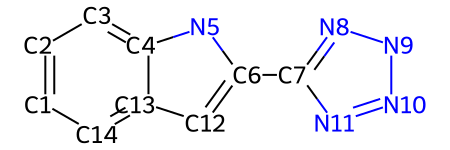

In [4]:
from rdkit.Chem.Draw import IPythonConsole
import rdkit.Chem as Chem
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

mol = Chem.MolFromSmiles('C1=CC=C2[NH]C(C3=N[NH]N=N3)=CC2=C1')
for j, a in enumerate(mol.GetAtoms()):
    a.SetProp('atomLabel', f"{a.GetSymbol()}{j+1}")
mol